In [ ]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import umap
from transformers import pipeline
from huggingface_hub import login

# Login
login(token="your-token")

print("Setup complete!")

# Quick test with a simple image to make sure pipeline works
print("\\nTesting DINOv3 pipeline with simple test image...")
test_img = Image.new('RGB', (224, 224), color='red')
test_feature_extractor = pipeline(
    model="facebook/dinov3-vitb16-pretrain-lvd1689m",
    task="image-feature-extraction"
)

try:
    test_features = test_feature_extractor(test_img)
    print(f"✅ Pipeline test successful!")
    print(f"Test features type: {type(test_features)}")
    print(f"Test features length: {len(test_features)}")
    if len(test_features) > 0:
        print(f"Test feature vector shape: {np.array(test_features[0]).shape}")
except Exception as e:
    print(f"❌ Pipeline test failed: {e}")

Setup complete!
\nTesting DINOv3 pipeline with simple test image...


Device set to use cpu


✅ Pipeline test successful!
Test features type: <class 'list'>
Test features length: 1
Test feature vector shape: (201, 768)


Loaded glacier image: (1209, 4686)


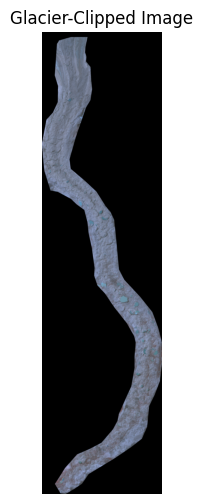

In [23]:
# Load your glacier-clipped image
image_path = "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_clip_by_glacier.tif"  # UPDATE THIS PATH

# Load image - handle both PIL and rasterio formats
try:
    # Try PIL first
    glacier_image = Image.open(image_path)
    if glacier_image.mode != 'RGB':
        glacier_image = glacier_image.convert('RGB')
except:
    # Fallback to rasterio for .tif files
    import rasterio
    with rasterio.open(image_path) as src:
        img_array = src.read()[:3]  # Take first 3 bands (RGB)
        img_array = np.transpose(img_array, (1, 2, 0))  # HWC format
        glacier_image = Image.fromarray(img_array.astype(np.uint8))

print(f"Loaded glacier image: {glacier_image.size}")

# Display
plt.figure(figsize=(10, 6))
plt.imshow(glacier_image)
plt.title('Glacier-Clipped Image')
plt.axis('off')
plt.show()

In [24]:
# Extract DINOv3 features
print("Loading DINOv3...")
feature_extractor = pipeline(
    model="facebook/dinov3-vitb16-pretrain-lvd1689m",
    task="image-feature-extraction"
)

print("Extracting features...")
print(f"Image size: {glacier_image.size}")
print(f"Image mode: {glacier_image.mode}")

# Check if image is too small
if glacier_image.size[0] < 50 or glacier_image.size[1] < 50:
    print("⚠️  Image might be too small for DINOv3. Resizing...")
    glacier_image = glacier_image.resize((224, 224))

try:
    features = feature_extractor(glacier_image)
    print(f"Features extracted successfully!")
    print(f"Features type: {type(features)}")
    print(f"Features content: {features}")
    
    if features and len(features) > 0:
        feature_vector = np.array(features[0])
        print(f"Feature vector shape: {feature_vector.shape}")
        if feature_vector.size > 0:
            print(f"Feature range: {feature_vector.min():.3f} to {feature_vector.max():.3f}")
        else:
            print("❌ Feature vector is empty!")
    else:
        print("❌ No features returned!")
        
except Exception as e:
    print(f"❌ Error extracting features: {e}")
    print("This might be due to image format or size issues.")

Loading DINOv3...


Device set to use cpu


Extracting features...
Image size: (1209, 4686)
Image mode: RGB


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
# Extract DINOv3 features
print("Loading DINOv3...")
feature_extractor = pipeline(
    model="facebook/dinov3-vitb16-pretrain-lvd1689m",
    task="image-feature-extraction"
)

print("Extracting features...")
features = feature_extractor(glacier_image)
feature_vector = np.array(features[0])

print(f"Feature vector shape: {feature_vector.shape}")
print(f"Feature range: {feature_vector.min():.3f} to {feature_vector.max():.3f}")

Loading DINOv3...


Device set to use cpu


Extracting features...
Feature vector shape: (201, 768)
Feature range: -6.989 to 17.908


In [26]:
# That's it! You now have the DINOv3 feature vector for your glacier image
print("DINOv3 feature extraction complete!")
print(f"Your glacier image is represented by {len(feature_vector)} features")

# Show first 10 features as example
print(f"First 10 features: {feature_vector[:10]}")

DINOv3 feature extraction complete!
Your glacier image is represented by 201 features
First 10 features: [[ 0.99112129  0.80226874 -0.22866254 ... -0.95160401 -0.71860695
   0.2697258 ]
 [-0.09182095  0.11630065  0.15644535 ...  0.32632014 -0.08437462
  -0.04993486]
 [-0.03434681  0.09272115 -0.11047738 ...  0.19594687 -0.06965767
  -0.11857653]
 ...
 [ 0.42426813  0.47790706 -0.31018963 ... -0.67798293 -0.18466347
   0.61013055]
 [ 0.28688639  0.34286788 -0.33042783 ... -0.5454191   0.02887517
   0.62039948]
 [ 0.36952043  0.42828563 -0.25603238 ... -0.58519483 -0.05630255
   0.58346456]]


In [27]:
# For multiple glacier images - UMAP clustering
image_paths = [
    "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_clip_by_glacier.tif",
    "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-10-15_fcc_clip_by_glacier.tif", 
    # Add more paths...
]

if len(image_paths) > 1 and all(path != "/path/to/glacier_image1.tif" for path in image_paths):  # Only run if you've updated paths
    print(f"Processing {len(image_paths)} images for UMAP clustering...")
    
    all_features = []
    image_names = []
    
    for i, path in enumerate(image_paths):
        print(f"  Processing {path}...")
        
        # Load image with error handling
        try:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
        except:
            import rasterio
            with rasterio.open(path) as src:
                img_array = src.read()[:3]  # Take RGB only
                img_array = np.transpose(img_array, (1, 2, 0))
                img = Image.fromarray(img_array.astype(np.uint8))
        
        # Extract features
        features = feature_extractor(img)
        
        # DEBUG: Check what we actually get from the pipeline
        print(f"    Raw features type: {type(features)}")
        print(f"    Raw features length: {len(features)}")
        print(f"    First element type: {type(features[0])}")
        print(f"    First element shape: {np.array(features[0]).shape}")
        
        # Handle different possible formats
        if isinstance(features[0], list):
            # If it's a nested list, flatten it
            feature_vector = np.array(features[0]).flatten()
        else:
            # If it's already an array
            feature_vector = np.array(features[0])
            if feature_vector.ndim > 1:
                feature_vector = feature_vector.flatten()
        
        print(f"    Final feature vector shape: {feature_vector.shape}")
        print(f"    Feature vector dimensionality: {feature_vector.ndim}")
        
        all_features.append(feature_vector)
        image_names.append(f"Image_{i+1}")
    
    # Convert to numpy array and debug
    print(f"\\nBefore stacking:")
    for i, feat in enumerate(all_features):
        print(f"  Feature {i} shape: {feat.shape}, dims: {feat.ndim}")
    
    features_matrix = np.array(all_features)
    print(f"\\nFeature matrix shape: {features_matrix.shape}")
    print(f"Feature matrix dimensions: {features_matrix.ndim}")
    print(f"Expected: 2D array with shape (n_images, n_features)")
    
    # Only proceed with UMAP if we have a proper 2D array
    if features_matrix.ndim == 2:
        print("✅ Correct format for UMAP")
        
        # UMAP clustering
        print("Running UMAP...")
        umap_reducer = umap.UMAP(n_components=2, random_state=42)
        umap_result = umap_reducer.fit_transform(features_matrix)
        
        print(f"UMAP result shape: {umap_result.shape}")
        
        # Plot results
        plt.figure(figsize=(10, 8))
        plt.scatter(umap_result[:, 0], umap_result[:, 1], s=100, alpha=0.7)
        
        # Label each point
        for i, name in enumerate(image_names):
            plt.annotate(name, (umap_result[i, 0], umap_result[i, 1]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=12)
        
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.title('UMAP Clustering of Glacier Images (DINOv3 Features)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calculate distances between images
        from sklearn.metrics.pairwise import euclidean_distances
        distances = euclidean_distances(features_matrix)
        
        print(f"\\nPairwise distances between images:")
        for i in range(len(image_names)):
            for j in range(i+1, len(image_names)):
                print(f"  {image_names[i]} ↔ {image_names[j]}: {distances[i,j]:.3f}")
    else:
        print(f"❌ Wrong format for UMAP: {features_matrix.shape}")
        print("Features need to be flattened properly. Check the debug output above.")
            
else:
    print("Update the image_paths list above with your actual file paths to run UMAP clustering")

Processing 2 images for UMAP clustering...
  Processing /Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_clip_by_glacier.tif...
    Raw features type: <class 'list'>
    Raw features length: 1
    First element type: <class 'list'>
    First element shape: (201, 768)
    Final feature vector shape: (154368,)
    Feature vector dimensionality: 1
  Processing /Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-10-15_fcc_clip_by_glacier.tif...
    Raw features type: <class 'list'>
    Raw features length: 1
    First element type: <class 'list'>
    First element shape: (201, 768)
    Final feature vector shape: (154368,)
    Feature vector dimensionality: 1
\nBefore stacking:
  Feature 0 shape: (154368,), dims: 1
  Feature 1 shape: (154368,), dims: 1
\nFeature matrix shape: (2, 154368)
Feature matrix dimensions: 2
Expected: 2D array with shape (n_images, n_features)
✅ Correct format for UMAP
Running UMAP...


/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/varyabazilova/opt/anaconda3/envs/superlakes/lib/python3.11/site-packages/umap/umap_.py:134: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = inf has removed 0 edges.
It has fully disconnected 2 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


ValueError: zero-size array to reduction operation maximum which has no identity

In [21]:
# Optional: If you have multiple glacier images for clustering
image_paths = [
    "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_clip_by_glacier.tif",
    "/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-10-15_fcc_clip_by_glacier.tif"
    # "/path/to/glacier_image3.tif",
    # Add more paths...
]

if len(image_paths) > 1:  # Only run if you have multiple images
    print(f"Processing {len(image_paths)} images for UMAP clustering...")
    
    all_features = []
    image_names = []
    
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        features = feature_extractor(img)
        all_features.append(np.array(features[0]))
        image_names.append(f"Image_{i+1}")
        print(f"  Processed {path}")
    
    # Stack features
    features_matrix = np.array(all_features)
    print(f"Feature matrix shape: {features_matrix.shape}")
    
    # UMAP clustering
    print("Running UMAP...")
    umap_reducer = umap.UMAP(n_components=2, random_state=42)
    umap_result = umap_reducer.fit_transform(features_matrix)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_result[:, 0], umap_result[:, 1], s=100)
    
    # Label points
    for i, name in enumerate(image_names):
        plt.annotate(name, (umap_result[i, 0], umap_result[i, 1]), 
                    xytext=(5, 5), textcoords='offset points')
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Clustering of DINOv3 Features')
    plt.grid(True, alpha=0.3)
    plt.show()
    
else:
    print("Add multiple image paths above to run UMAP clustering")

Processing 2 images for UMAP clustering...
  Processed /Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-09-04_fcc_clip_by_glacier.tif
  Processed /Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_data/2021-10-15_fcc_clip_by_glacier.tif
Feature matrix shape: (2, 201, 768)
Running UMAP...


ValueError: Found array with dim 3, while dim <= 2 is required.

In [6]:
# Save your feature vector
np.save('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/glacier_features.npy', 
        feature_vector)

print("Feature vector saved to glacier_features.npy")
print("Done!")

Feature vector saved to glacier_features.npy
Done!
